## Store-sales time-series forecasting Model 1

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

First we import the data from the various files. It is convenient to set the data types and pare the dates for the train and test sets.

In [6]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

train = pd.read_csv('train.csv', parse_dates = ['date'], dtype=dtype)
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['store_nbr', 'family', 'date']).sort_index()


test = pd.read_csv('test.csv', parse_dates = ['date'], dtype=dtype)
test['date'] = test.date.dt.to_period('D')

oil = pd.read_csv('oil.csv', parse_dates = True, index_col=['date']).to_period('D')
holidays_events = pd.read_csv('holidays_events.csv', parse_dates = True, index_col=['date']).to_period('D')
transactions = pd.read_csv('transactions.csv', parse_dates = True, index_col=['date']).to_period('D')

We are going to start the analysis of the data by looking at the spectrum of frequencies given by the fourier transform of the
data. The function in the cell below plots the spectrum given a data set and assuming a linear trend (based on an anlysis below on this notebook)

In [7]:
def fourier_periods(ts, detrend='linear'):
    from scipy.signal import periodogram
    freqencies, power_spectrum = periodogram(
        ts,
        fs=366,
        detrend=detrend,# We assume a linear trend, see the anlysis of trends below
        window="boxcar",
        scaling='spectrum',
    )
    plt.figure(figsize=(8, 4), layout='constrained')
    plt.step(freqencies, power_spectrum, color="blue")
    plt.xscale("log")
    plt.xticks([1, 2, 4, 6, 12, 26, 52, 104], ["Annual (1)","Semiannual (2)","Quarterly (4)","Bimonthly (6)","Monthly (12)",
                                               "Biweekly (26)","Weekly (52)", "Semiweekly (104)"], rotation=90)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    plt.ylabel("Power Spectral density")
    plt.title("Frequency spectrum")
    return plt.show()

We use this function to the average of sales for all the stores and intem categories for the whole time range.

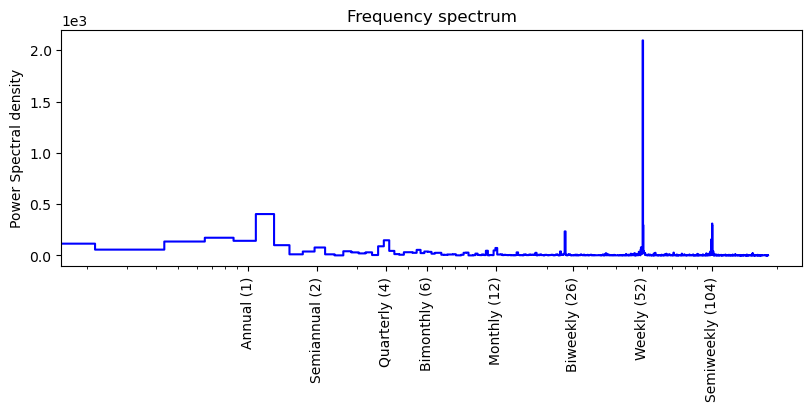

In [8]:
start='2013-01-01' #data starts at 2013-01-01
end='2017-08-15' #data ends at 2017-08-015
avg_sales = train.groupby('date').mean()['sales'].loc[start:end]
fourier_periods(avg_sales)

We see that the main frequency corresponds to a weekly period, with smaller contributions from semiweekly and biweekly frequencies. Some other, less defined structures appear at longer time periods particularly for yearly and longer. The latter increase if we remove the linear detrend in the periodogram function. Reducing the time period for which we consider the data has the effect of removing this longer time frequencies (as one would expect). 

Now we want look if the long time trend is related to oil prices. To this effect we look at the correlation of the average sales with oil price. Additionaly we also look at the correlation with the sales rolling averages for various time windows as well as the average for stores transactions and promotions.

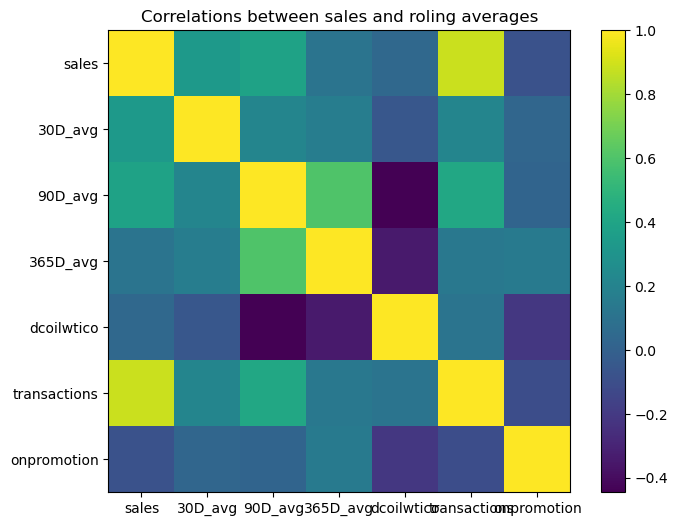

In [9]:
start='2017-01-15' #data starts at 2013-01-01
end='2017-08-15' #data ends at 2017-08-015
avg_transactions = transactions.groupby('date').mean()[['transactions']].loc[start:end]
avg_sales = train.groupby('date').mean()[['sales']].loc[start:end]
avg_promo = train.groupby('date').mean()[['onpromotion']].loc[start:end]
avg_sales['30D_avg'] = avg_sales['sales'].rolling(window = '7D', min_periods=1, center = True).mean()
avg_sales['90D_avg'] = avg_sales['sales'].rolling(window = '30D', min_periods=1, center = True).mean()
avg_sales['365D_avg'] = avg_sales['sales'].rolling(window = '90D', min_periods=1, center = True).mean()
avg_sales = avg_sales.join(oil)
avg_sales = avg_sales.join(avg_transactions)
avg_sales = avg_sales.join(avg_promo)
fig, ax = plt.subplots(figsize=(8,6))
labels = avg_sales.corr().index
im = ax.imshow(avg_sales.corr())
ax.set_xticks(np.arange(len(labels)), labels=labels)
ax.set_yticks(np.arange(len(labels )), labels=labels)
plt.colorbar(im)
ax.set_title('Correlations between sales and roling averages')
plt.show()

Unfortunately no strong correlation is observed with oil. Average transactions is strongly correlated with sales, but since there is no transaction data for the test period we will not consider it.

Next we will try to find a model for the trend of the average sales. For this we define a function that plots the sales or rolling averages of the sales in a time period and fits a polynominomial, which is also ploted.

In [10]:
def trend_plot(start,end,order,window):
    avg_sales = train.groupby('date').mean()['sales'].rolling(window = window, min_periods=1, center = True).mean()
    avg_sales_slice = avg_sales.loc[start:end]

    index=avg_sales_slice.index

    dp = DeterministicProcess(index=index , order=order, drop=True, constant= False)

    y = avg_sales_slice.values
    X = dp.in_sample()
    X_forecast = dp.out_of_sample(steps=16)


    model = LinearRegression()
    model.fit(X, y)
    y_pred = pd.Series(model.predict(X), index=index)
    y_forecast = pd.Series(model.predict(X_forecast), index=X_forecast.index)
    y_true =  avg_sales.loc[X_forecast.index]
    
    score_fit = model.score(X, y)
    score_forecast = model.score(X_forecast, y_true)
    print(f'Score of the fit={score_fit:.3f}')
    print(f'Score of the forecast={score_forecast:.3f}')
        
    fig, ax = plt.subplots(figsize=(9, 3), layout='constrained')

    ax.plot(index.to_timestamp(),y)
    ax.plot(X_forecast.index.to_timestamp(), y_true)
    ax.plot(y_pred)
    ax.plot(y_forecast)
    ax.set(title="Avg "+window+" Sales", ylabel="Do not actually know the units", xlabel="Dates");
    return plt.show()

Score of the fit=0.513
Score of the forecast=-0.075


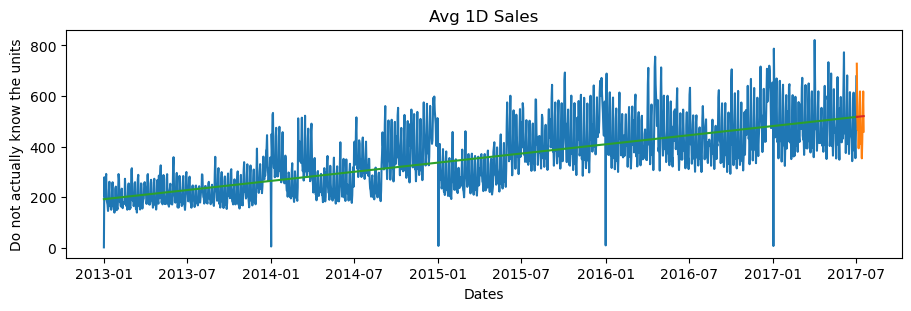

In [11]:
#data starts at 2013-01-01
#data ends at 2017-08-15
trend_plot('2013-01-01','2017-07-01',1,'1D')

The linear trend somewhat captures the oveall evolution of the sales but does not provide any accuracy for predictions of small time periods like the one in the test data set.

Score of the fit=0.957
Score of the forecast=-20.507


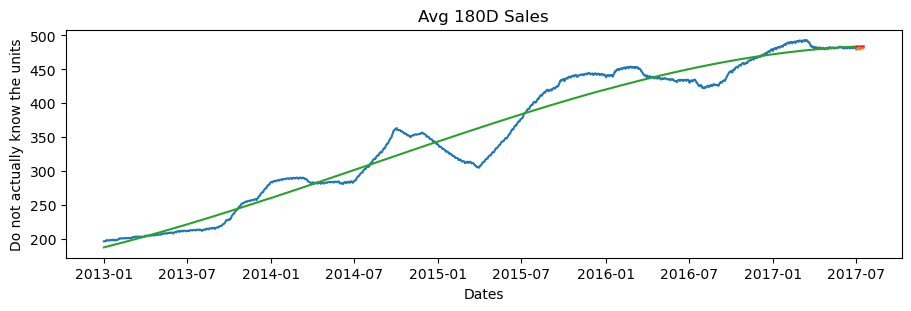

In [12]:
trend_plot('2013-01-01','2017-07-01',3,'180D')

Even considering a long time rolling average and high order polynomials we cannot find a fit of the sales trend with good predictivity.

Score of the fit=0.310
Score of the forecast=0.177


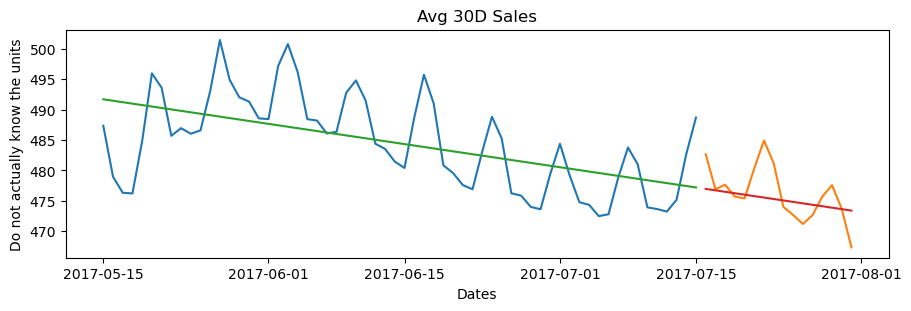

In [13]:
trend_plot('2017-05-15','2017-07-15',1,'30D')

Shorter time periods have worst fits but better trend predictivity.

Given what we have learned so far we create a linear model for each store and sales family (outcomes) consisting of the same set of features: seasonal weekly features and a linear trend. Note that the LinearRegression model suports multiple outcomes and that the parameters are fitted independently for each outcome. We also add options (commented lines) for fourier features for monthly and yearly periodicity (and multiples of that) as well as oil price as feature. One limitation of this model is that we cannot add outcome specific features like the holidays for each specific store.

As we have seen, we have not found a good way to fit the long time trend and therefore fitting the model to short time periods seems the best apporach to minimize the error in the trend. However the time period should be long enough to train the weekly seasonal features, thus a few months should be optimal. 

The code below implements this strategy, which has the advantage of being very simple. There are additional (commented) code line to implement other features for the time series prediction. These are fourier features with monthly and yearly periodicities (and multiples of these). Playing with this we can observe that if we are using a training period of a few months adding this new features just overfits the data leading to worst predictions. For long enough time periods of training data these extra features do improve the model but do not compesate for the worst trend prediction associted to large time periods. Oil price features can also be tried by uncommenting the corresponding lines, but do not improve the model as expected from the lack of correlation with sales.

Finaly the code below has two outcomes depending on the chosen end date for the training data. If we use the actual end date of the training file ('2017-08-15') it write the predictions for the test file sales in a submission file to upload to Kaggle. The second mode allows to test the model without submiting to Kaggle by predicting a 16 day period of the train data. To do so the end date is set up to '2017-07-30' and the time period of the train data is used to predict the next 16 days of sales. Then the Root Mean Squared Logarithmic Error is computed and printed using the corresponding sales data from the train file.

In [15]:
start='2017-03-15'
end='2017-08-15'

y = train[['sales']].unstack(['store_nbr', 'family']).loc[start:end]

index = y.index

#fourier_1 = CalendarFourier('A', 1)
#fourier_2 = CalendarFourier('M', 1)

dp = DeterministicProcess(index = index,
#                          constant=True,
                          order = 1,
                          drop= True,
                          seasonal = True,
                          period = 7,
#                          additional_terms=[fourier_1,fourier_2]
#                          additional_terms=[fourier_2]
                         )

#holidays = holidays_events.query("locale == 'National' and type == 'Additional' or description in ['Primer dia del ano','Navidad']").loc[start:end, ['description']]
#X_holidays = pd.DataFrame(
#    OneHotEncoder(sparse=False, categories= [holidays.description.unique()]).fit_transform(holidays),
#    index=holidays.index,
#    columns=holidays.description.unique(),
#)

X = dp.in_sample()
#X = X.join(oil['dcoilwtico']).fillna(method='pad').fillna(method='bfill')
#X = X.join(X_holidays).fillna(0)

X_forecast = dp.out_of_sample(steps=16)
#X_forecast = X_forecast.join(oil['dcoilwtico']).fillna(method='pad').fillna(method='bfill')
#X_forecast = X_forecast.join(X_holidays).fillna(0)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index = index, columns=y.columns)
y_forecast = pd.DataFrame(model.predict(X_forecast), index = X_forecast.index, columns=y.columns)
y_submit = y_forecast.stack(['store_nbr', 'family']).reset_index()
y_submit.loc[y_submit['sales'] < 0, 'sales'] = 0


if end =='2017-08-15':
    y_submit = y_submit.join(test[['id']])
    y_submit.to_csv('submission.csv', index=False, columns =['id','sales'])
else:
    y_f_true = train[['id','sales']].unstack(['store_nbr', 'family']).loc[X_forecast.index]
    y_f_true = y_f_true.stack(['store_nbr', 'family']).reset_index()[['id','sales']]
    RMSLE = np.sqrt((np.sum(np.log((1+y_submit['sales'].values)/(1+y_f_true['sales'].values))**2)/len(y_f_true)))
    print(f'RMSLE = {RMSLE:.3f}')

RMSLE = 0.477


Finaly we add that RMSLE is which is fairly good for such a simple model.